In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.parametrize as parameterize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
"""
Load the data set we will be working with
"""

data_dir = 'Datasets'

df = pd.read_csv(f'{data_dir}/study_373/top_5_373.csv')

# For dataset 373, the input data is blocked by year to avoid large jumps
train = [df[df['DATE'] < '2009'], df[df['DATE'].between('2009', '2010')], df[df['DATE'].between('2009', '2011')], df[df['DATE'].between('2011', '2012')]]
test = df[df['DATE'] >= '2012']

print(len(df))
print(len(test))
for d in train:
    print(len(d))

393
74
25
102
224
70


In [10]:
# the lag is the amount of historical data we provide to the model
lag = 10

# The adjacency matrix for study 373, note that some modifications were made. In the adj_373.py file,
# a directed adjacency matrix was provided. For the network autoregressive model, an independent model is trained
# for each direction on an edge, so we actually want a symmetric adjacency matrix. This will allow prey populations
# to be influenced by predator populations and predator populations to be influenced by prey populations
adjacency_matrix = np.array([
    [0, 0, 1, 0, 1],  # Common Raccoon Dog preys on Japanese Hare and Rodents
    [0, 0, 1, 0, 1],  # Wild Boar preys on Japanese Hare and Rodents
    [1, 1, 0, 0, 0],  # Japanese Hare doesn't prey on any of the listed animals
    [0, 0, 0, 0, 1],  # Japanese Badger preys on Rodents
    [1, 1, 0, 1, 0]   # Rodents don't prey on any of the listed animals
])

In [11]:
class logexp(nn.Module):
    def forward(self, X):
        return torch.exp(X)

class NARModel(nn.Module):

    def __init__(self, lag, adj_mat):
        super().__init__()

        # We will use the adj_mat to determine which linear models need to be applied
        self.adj_mat = adj_mat
        self.channels = len(adj_mat)

        # The basic autoregressive model is simply a linear combination of the last values
        # For the network varient, we will create a matrix of linear models, applying the ones that
        # correspond to edges in the underlying network
        # Note that in reality, each linear model should have lag inputs and only one output, however to simplify
        # working with torch, we allow for self.channels outputs, which will then by multiplied by a vector with exactly
        # one coordinate set to one. This will effectively reduce the number of outputs to one, but will make vector
        # operations in the forward pass easier
        self.model = nn.ModuleList([nn.ModuleList([nn.Linear(lag, self.channels) for _ in range(self.channels)]) for _ in range(self.channels)])

        # We can require all weights to be positive using the above logexp module
        # that relate an element to itself
        for i in range(self.channels):
            for j in range(self.channels):
                parameterize.register_parametrization(self.model[i][j], 'weight', logexp())

        # store the lag in case we need it
        self.lag = lag

        # store the identity matrix, which is used to simplify the forward pass
        self.eye = torch.eye(self.channels)

    def forward(self, input):
        output = torch.zeros(self.channels)

        for i in range(self.channels):
            # We always apply the auto regressive model to the current node
            output += self.model[i][i](input[i]) * self.eye[i]

            # For each other node, we only apply the model if the nodes are connected
            # in the adjacency matrix
            for j in range(self.channels):
                if self.adj_mat[i][j] == 0 or j == i: continue
                output += self.model[i][j](input[j]) * self.eye[i]

        # Since it is impossible for species populations to be negative, we apply a relu to the
        # final result
        return nn.functional.relu(output)
    
    def fit(self, data, iters = 100, lr = 0.001, verbose = False):
        # We will use 100 iterations of stochastic gradient descent with a learning rate
        # of 0.001
        optimizer = optim.SGD(self.parameters(), lr = lr)

        # Mean Square Error loss
        loss_fn = nn.MSELoss()

        # First generate the sequences of inputs and outputs in the proper tensor format
        input, output = [], []
        for i in range(self.lag, len(data[0])):
            curr_input = []
            curr_output = []
            for j in range(self.channels):
                curr_input.append(data[j][i - self.lag:i])
                curr_output.append(data[j][i])
            input.append(torch.tensor(curr_input, dtype = torch.float32))
            output.append(torch.tensor(curr_output, dtype = torch.float32))

        for _ in range(iters):
            total_loss = 0
            for x, y in zip(input, output):
                # We need to zero the gradients for each optimization step
                optimizer.zero_grad()

                # Calculate the loss for this step
                pred = self.forward(x)
                loss = loss_fn(pred, y)
                total_loss += loss

                # Backpropagate the loss
                loss.backward()

                # Step the optimizer forward to update the parameters
                optimizer.step()
            if verbose: print(f'total loss: {total_loss:.4f}')


In [12]:
model = NARModel(lag, adjacency_matrix)

for table in train:
    all_data = []
    for s in table.columns:
        if s == 'DATE': continue
        all_data.append(table[s].tolist())
    model.fit(all_data, verbose=False)

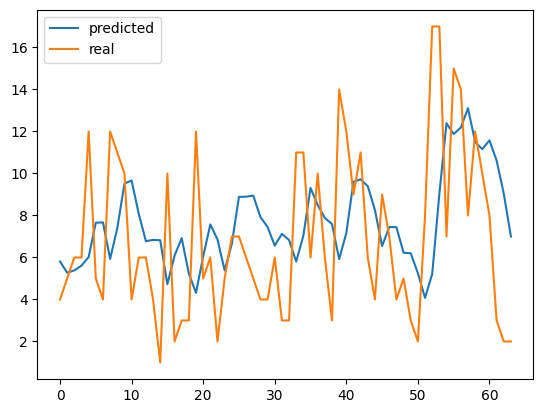

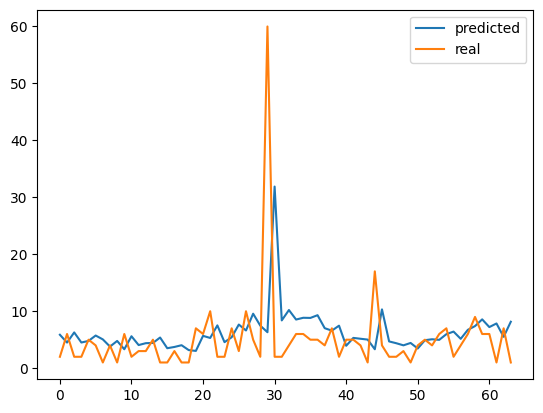

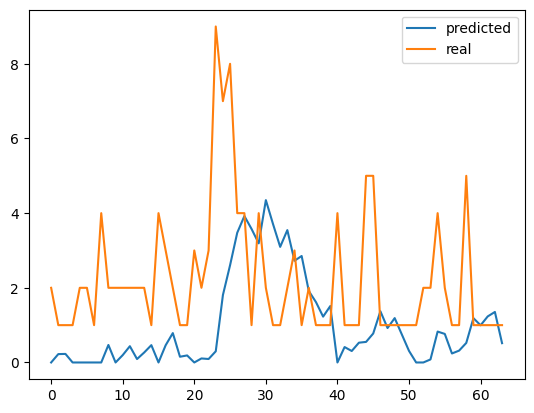

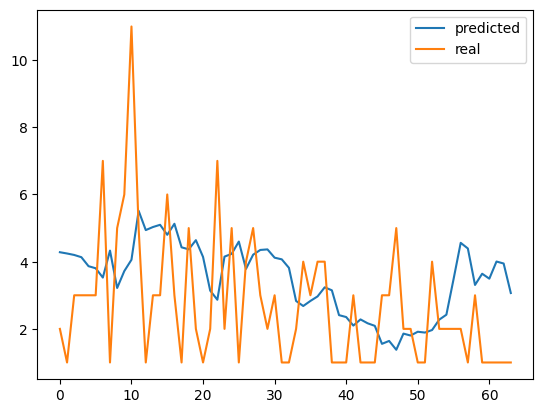

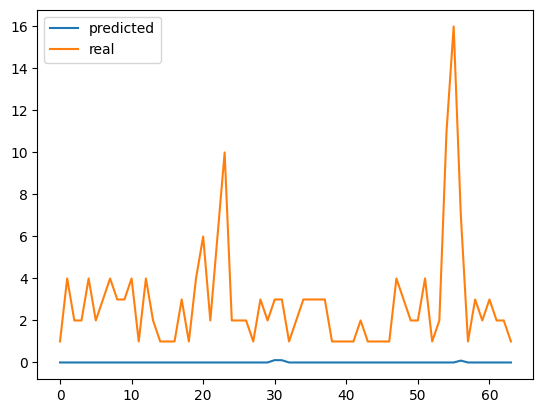

In [15]:
x = [i for i in range(len(test) - lag)]

data = []
for s in test.columns:
    if s == 'DATE': continue
    data.append(test[s].tolist())

for s in range(len(data)):
    _, ax = plt.subplots()
    expected, predictions = [], []
    for i in range(lag, len(test)):
        input = []
        for stream in data:
            input.append(stream[i - lag:i])
        expected.append(data[s][i])
        input = torch.tensor(input, dtype = torch.float32)
        predictions.append(model.forward(input).detach().numpy()[s])
        
    ax.plot(x, predictions, label = 'predicted')
    ax.plot(x, expected, label = 'real')
    plt.legend()
    plt.show()

In [14]:
for ml in model.model:
    for l in ml:
        display(l.weight)

tensor([[0.0543, 0.0267, 0.0216, 0.0219, 0.0232, 0.0206, 0.0278, 0.1172, 0.2942,
         0.2513],
        [0.7511, 0.7960, 1.1604, 1.2298, 0.8202, 0.7829, 0.7812, 1.2809, 0.7778,
         0.8217],
        [1.2518, 0.9954, 0.9089, 0.8981, 0.8026, 0.7353, 1.1972, 0.9059, 1.3661,
         0.7341],
        [1.0431, 1.1460, 0.9438, 0.8259, 1.1114, 0.7356, 1.0345, 0.7419, 0.8930,
         1.2865],
        [1.0626, 1.1565, 1.0391, 1.0006, 1.1681, 1.2339, 0.7630, 1.3040, 1.3252,
         0.8390]], grad_fn=<ExpBackward0>)

tensor([[0.8852, 1.1804, 0.7636, 0.8727, 0.9047, 1.3231, 1.0864, 1.0264, 0.9227,
         1.2067],
        [0.8949, 1.0289, 1.3076, 1.0199, 0.7318, 1.1498, 1.1672, 0.7470, 1.3084,
         1.1601],
        [0.9527, 0.9205, 1.1267, 1.2635, 0.9980, 1.2265, 1.0558, 0.8964, 0.8686,
         0.7625],
        [1.1327, 1.0573, 1.0241, 1.0223, 1.3371, 1.3070, 1.1058, 0.9668, 0.8217,
         0.7316],
        [0.8498, 0.8812, 1.2719, 0.7417, 0.7883, 1.1479, 0.8332, 1.0565, 1.2072,
         1.1054]], grad_fn=<ExpBackward0>)

tensor([[0.0678, 0.0767, 0.0454, 0.0359, 0.0303, 0.0444, 0.0427, 0.0390, 0.1743,
         0.1123],
        [1.0695, 0.7591, 1.3389, 1.2379, 1.2863, 0.7368, 1.1305, 1.0338, 0.8095,
         0.8821],
        [0.9798, 1.1322, 1.1788, 0.8653, 1.0565, 0.9660, 1.3534, 1.0880, 0.9426,
         1.3154],
        [1.0186, 1.2340, 1.0474, 0.8807, 0.9660, 1.2947, 1.3409, 1.1313, 0.9642,
         1.1725],
        [0.9158, 1.0151, 0.9315, 0.7831, 0.8169, 0.8069, 1.2940, 1.0749, 1.1342,
         1.1648]], grad_fn=<ExpBackward0>)

tensor([[0.8675, 0.7382, 0.8288, 1.1181, 0.7790, 1.2180, 1.0838, 0.8770, 1.2857,
         1.0430],
        [0.7783, 1.2567, 0.8198, 0.7292, 0.7797, 0.7790, 0.7335, 0.9226, 0.9780,
         1.0246],
        [0.8623, 1.1294, 0.7778, 1.2767, 1.2019, 1.2757, 0.7456, 1.0876, 1.0282,
         1.1408],
        [1.1959, 1.3500, 0.8768, 0.8187, 0.9355, 1.1174, 1.2588, 1.2049, 1.0047,
         1.2884],
        [0.9306, 1.0684, 0.7354, 1.0307, 0.9598, 1.1408, 1.1214, 0.9362, 0.8423,
         1.2604]], grad_fn=<ExpBackward0>)

tensor([[0.0301, 0.0555, 0.0389, 0.0393, 0.0386, 0.0418, 0.0546, 0.0337, 0.0940,
         0.0634],
        [1.0001, 0.9950, 0.8515, 1.1106, 0.7443, 0.9316, 1.1493, 1.3011, 0.9882,
         0.7906],
        [1.1370, 1.3237, 1.0817, 0.8579, 1.0518, 1.1106, 0.8726, 1.0105, 0.9529,
         1.0532],
        [1.1643, 1.1804, 0.9297, 1.3243, 0.7969, 0.8542, 1.0428, 0.9732, 1.2660,
         1.0536],
        [0.9108, 1.1912, 1.2268, 0.8657, 1.1709, 0.8229, 0.8779, 1.0473, 1.1764,
         1.3706]], grad_fn=<ExpBackward0>)

tensor([[1.2816, 1.0834, 0.8733, 0.8132, 1.1468, 1.1471, 1.2921, 0.8393, 0.8023,
         0.9270],
        [1.2362, 1.2256, 0.9472, 1.2465, 1.0556, 0.7631, 0.8708, 0.7987, 0.8238,
         1.2328],
        [1.2989, 1.0452, 1.2307, 1.3377, 0.8360, 1.1934, 0.7996, 0.9458, 1.1204,
         0.7807],
        [0.8418, 0.7470, 0.8459, 0.8007, 1.2831, 0.9573, 0.8574, 0.9259, 0.8930,
         1.3367],
        [0.9895, 1.1327, 1.2784, 0.8757, 1.0926, 0.9766, 0.8109, 1.0279, 1.1899,
         1.2435]], grad_fn=<ExpBackward0>)

tensor([[1.0559, 0.8084, 0.7454, 0.9126, 1.0281, 0.9532, 1.3649, 1.3001, 1.1883,
         0.7890],
        [0.0207, 0.0244, 0.0271, 0.0625, 0.0463, 0.0359, 0.0313, 0.0690, 0.0386,
         0.4444],
        [1.2383, 1.1164, 1.0125, 0.9153, 0.8565, 0.8380, 0.9545, 1.2860, 1.3606,
         1.0021],
        [1.0961, 0.9253, 0.9221, 1.1837, 1.0344, 0.7823, 1.0956, 1.1486, 0.8339,
         1.0412],
        [0.8220, 1.3646, 1.1706, 1.3695, 1.0225, 0.7710, 0.8564, 1.0671, 1.3696,
         1.0889]], grad_fn=<ExpBackward0>)

tensor([[0.9653, 0.7858, 1.1198, 0.7864, 0.9004, 1.0644, 1.1291, 1.3303, 0.8107,
         0.8868],
        [0.0363, 0.1288, 0.0727, 0.0542, 0.0339, 0.0367, 0.0532, 0.0618, 0.0401,
         0.0487],
        [1.0537, 0.7300, 1.0141, 0.9770, 1.1250, 0.9559, 1.2380, 1.0102, 1.0993,
         1.2672],
        [0.8872, 0.9305, 1.3205, 0.8795, 0.8797, 0.7839, 1.2472, 1.0239, 1.1391,
         1.0501],
        [0.8781, 0.9274, 1.1601, 1.1438, 1.1666, 0.8789, 0.8848, 1.2465, 0.7789,
         0.9550]], grad_fn=<ExpBackward0>)

tensor([[1.2287, 1.0666, 0.7963, 0.9606, 1.1759, 0.8216, 0.8093, 0.8626, 0.8489,
         0.8034],
        [1.2222, 1.1770, 1.2156, 0.8059, 0.9688, 1.1338, 0.9403, 1.2153, 0.8725,
         1.3139],
        [0.9644, 0.7450, 0.9239, 0.7540, 0.7578, 1.1925, 1.2365, 0.9482, 0.8889,
         0.7314],
        [1.1512, 0.9010, 0.9137, 1.0090, 1.0354, 1.2083, 0.7721, 1.3423, 1.1259,
         0.8824],
        [1.2343, 1.0254, 0.9598, 0.8093, 1.0599, 0.7903, 1.0896, 1.0737, 0.9413,
         1.3158]], grad_fn=<ExpBackward0>)

tensor([[1.0238, 1.2919, 1.3249, 0.7458, 1.1841, 1.0530, 0.9758, 0.8441, 1.2247,
         0.7872],
        [0.0408, 0.0370, 0.0640, 0.0513, 0.0468, 0.0391, 0.0448, 0.0934, 0.0563,
         0.0675],
        [1.1156, 0.9056, 0.8332, 1.3043, 0.8484, 0.7424, 1.2823, 1.0844, 1.2639,
         1.2810],
        [1.0508, 0.7571, 0.9072, 0.8992, 0.9266, 1.3650, 0.8660, 0.8898, 1.3494,
         1.0066],
        [0.7378, 1.3157, 0.8098, 0.9094, 1.1136, 0.9499, 0.7803, 1.1006, 1.3702,
         1.2306]], grad_fn=<ExpBackward0>)

tensor([[1.1724, 1.3386, 0.8181, 0.7946, 1.2248, 0.7463, 1.3630, 1.3377, 0.8780,
         1.0033],
        [1.3622, 1.0205, 1.0509, 0.9189, 0.7810, 0.9049, 0.7787, 0.7315, 0.9844,
         1.1574],
        [0.0142, 0.0144, 0.0134, 0.0114, 0.0131, 0.0137, 0.0126, 0.0131, 0.0175,
         0.0159],
        [0.8031, 1.2732, 0.9361, 0.9972, 1.0732, 1.2733, 0.8636, 1.3179, 1.3002,
         0.8142],
        [1.2544, 0.7552, 1.3401, 0.9888, 1.1757, 0.7837, 1.2971, 1.1309, 1.1522,
         0.7800]], grad_fn=<ExpBackward0>)

tensor([[0.8875, 1.0638, 0.9923, 1.0426, 1.1551, 0.8295, 1.0851, 0.8623, 1.2663,
         1.1671],
        [0.8664, 1.0480, 0.9187, 1.3363, 0.7611, 0.7525, 1.0737, 0.8488, 0.7621,
         0.7819],
        [0.0263, 0.0210, 0.0186, 0.0224, 0.0234, 0.0180, 0.0183, 0.0190, 0.0179,
         0.0213],
        [1.3234, 1.1509, 0.9775, 0.8543, 0.8376, 0.9863, 0.8438, 0.9606, 0.9358,
         0.8109],
        [0.9277, 1.2870, 0.8825, 0.9486, 0.7658, 0.8592, 0.8657, 0.7528, 0.8458,
         0.7993]], grad_fn=<ExpBackward0>)

tensor([[0.9892, 1.3574, 1.1980, 1.2255, 1.2190, 0.9609, 0.9484, 1.2390, 1.1455,
         1.3257],
        [0.8132, 0.7908, 1.1492, 1.2967, 1.1827, 1.3235, 1.2739, 0.8985, 0.7951,
         0.8961],
        [0.1412, 0.0886, 0.0841, 0.0948, 0.0882, 0.0626, 0.2210, 0.1480, 0.1296,
         0.2166],
        [0.9695, 0.8264, 1.0546, 1.2319, 0.9644, 1.1882, 1.1391, 1.1401, 0.9522,
         0.8142],
        [0.7443, 1.1481, 0.8187, 0.7735, 0.8339, 1.0983, 0.8581, 1.2536, 1.1881,
         1.3217]], grad_fn=<ExpBackward0>)

tensor([[1.2154, 0.7508, 0.9571, 0.8848, 0.7691, 1.2911, 0.7901, 0.9598, 0.8271,
         1.2971],
        [0.9113, 0.9017, 0.7406, 0.9134, 0.9632, 0.7964, 1.2489, 1.3477, 0.8270,
         1.0620],
        [0.9220, 0.8624, 1.0270, 1.2291, 0.8821, 0.8982, 0.7492, 0.7508, 0.9225,
         0.8078],
        [1.2351, 1.2813, 0.8403, 1.2825, 0.8751, 1.1864, 0.9251, 0.9864, 1.3119,
         1.0659],
        [1.1219, 1.3178, 1.1613, 0.7492, 0.7495, 1.0562, 1.1153, 1.0505, 0.8625,
         0.9409]], grad_fn=<ExpBackward0>)

tensor([[1.0582, 1.0610, 1.2092, 1.2558, 1.2462, 0.8650, 0.7723, 1.1719, 1.3262,
         0.7922],
        [0.9692, 0.7897, 0.7580, 0.8762, 1.0278, 0.9921, 1.1786, 0.8779, 0.7686,
         1.2433],
        [1.3127, 0.7507, 0.8731, 1.0254, 1.0024, 0.9009, 0.8256, 1.2217, 0.7697,
         0.8649],
        [0.7957, 0.8434, 0.9211, 1.2336, 1.0611, 1.3001, 1.1972, 1.3171, 1.1774,
         1.0246],
        [0.8411, 1.2698, 0.8261, 1.2773, 0.9499, 1.0211, 0.8186, 1.0579, 0.9990,
         1.0399]], grad_fn=<ExpBackward0>)

tensor([[0.8818, 0.9519, 0.8522, 1.3443, 0.9820, 1.0128, 0.7446, 1.0159, 1.1594,
         0.7420],
        [0.8511, 1.0836, 0.9762, 1.0993, 0.9105, 1.3056, 0.7968, 1.1084, 1.3307,
         0.7329],
        [1.0846, 0.8673, 0.7856, 1.1349, 1.3250, 0.9038, 0.9985, 0.8968, 1.0622,
         1.3424],
        [0.9978, 1.1802, 0.8096, 1.0670, 1.2019, 1.0292, 0.7313, 0.9839, 1.1215,
         1.3646],
        [1.2266, 1.2101, 1.0312, 0.9170, 0.7644, 0.7807, 1.2694, 0.7587, 1.0944,
         1.0188]], grad_fn=<ExpBackward0>)

tensor([[0.7547, 1.1429, 1.0633, 1.0330, 1.0023, 0.8668, 1.0164, 1.1290, 0.7567,
         0.8661],
        [1.1148, 1.1185, 1.0169, 1.0470, 1.3596, 0.7797, 0.7840, 1.2510, 1.2993,
         0.9877],
        [1.0901, 1.0153, 1.1782, 1.1978, 0.9841, 0.7346, 1.0964, 0.7699, 1.1797,
         1.2641],
        [1.1973, 1.1648, 1.1329, 0.8189, 1.2973, 0.8039, 0.7535, 0.8417, 1.0057,
         1.3042],
        [0.9478, 1.3534, 1.3574, 0.9964, 0.9639, 0.8817, 1.2339, 0.8133, 0.8808,
         1.2309]], grad_fn=<ExpBackward0>)

tensor([[0.8929, 0.8508, 0.8139, 1.1098, 1.0152, 1.2895, 0.8258, 0.8347, 0.7366,
         1.1633],
        [1.1696, 1.3227, 0.8147, 0.7979, 1.0533, 1.1493, 1.1128, 1.1467, 0.7519,
         1.1110],
        [0.9181, 0.9164, 1.2866, 0.9149, 1.0283, 0.9634, 1.2307, 1.1784, 0.7517,
         0.7551],
        [1.0898, 1.3546, 0.8067, 1.3060, 0.9761, 0.7346, 1.3144, 1.0599, 1.1942,
         0.7960],
        [0.9812, 0.9125, 0.8909, 1.2713, 0.9611, 0.7746, 1.2637, 1.1487, 1.1628,
         0.8981]], grad_fn=<ExpBackward0>)

tensor([[0.9965, 0.8442, 0.7707, 1.0817, 1.1247, 1.2165, 1.1067, 0.9297, 1.2932,
         0.9743],
        [1.2475, 0.8916, 0.9046, 1.2697, 0.9124, 0.7541, 0.9382, 0.9785, 0.9374,
         0.8623],
        [0.9452, 1.3619, 1.0059, 0.8794, 1.1976, 1.2613, 1.0868, 1.0496, 1.3452,
         0.9019],
        [0.1189, 0.0959, 0.0930, 0.1060, 0.0747, 0.1017, 0.1065, 0.0982, 0.0774,
         0.1747],
        [1.1045, 1.1033, 0.9308, 1.1166, 0.9878, 0.7482, 1.3507, 1.2885, 1.0309,
         0.7380]], grad_fn=<ExpBackward0>)

tensor([[0.9023, 1.0693, 0.8935, 0.9623, 0.9238, 0.9796, 0.9332, 0.8035, 1.0011,
         1.3005],
        [1.0744, 0.8286, 1.3670, 0.8110, 1.1972, 1.0218, 0.8090, 0.8244, 0.8043,
         0.8150],
        [1.0773, 0.9525, 1.1465, 1.0136, 1.2551, 1.1738, 0.9076, 1.0981, 0.8096,
         1.0075],
        [0.0415, 0.0450, 0.0449, 0.1007, 0.0650, 0.0654, 0.0519, 0.0546, 0.0646,
         0.1042],
        [0.9961, 1.0048, 0.8224, 1.2611, 1.1169, 0.9012, 1.0234, 1.3234, 0.7624,
         1.1179]], grad_fn=<ExpBackward0>)

tensor([[0.9241, 0.8341, 1.1650, 0.9182, 0.7310, 0.7403, 0.8159, 1.0711, 0.9921,
         0.8604],
        [1.0201, 0.9338, 1.1134, 0.8336, 1.2816, 1.0589, 1.3436, 0.8906, 0.9054,
         0.9132],
        [0.9831, 1.1085, 1.0576, 1.2866, 0.7914, 0.8930, 1.1648, 1.1714, 0.8520,
         1.0151],
        [0.9292, 0.9164, 0.7865, 1.3633, 0.7632, 1.1989, 0.7775, 0.7745, 0.7420,
         1.1283],
        [0.0201, 0.0174, 0.0210, 0.0228, 0.0195, 0.0260, 0.0346, 0.0277, 0.0222,
         0.0220]], grad_fn=<ExpBackward0>)

tensor([[1.3522, 1.0117, 0.9551, 0.7376, 1.1201, 0.9669, 1.1014, 1.3655, 0.8591,
         1.1533],
        [1.2935, 0.7720, 1.2770, 0.8876, 1.2529, 0.7831, 0.7855, 1.2236, 1.0995,
         1.1881],
        [1.2826, 1.1851, 0.9201, 0.7914, 1.0817, 1.0901, 0.7525, 0.7325, 1.1756,
         0.7469],
        [0.8326, 0.9406, 1.0067, 1.1828, 0.8564, 0.7825, 1.2973, 0.9301, 1.3430,
         0.8530],
        [0.0236, 0.0209, 0.0258, 0.0293, 0.0244, 0.0340, 0.0315, 0.0308, 0.0333,
         0.0271]], grad_fn=<ExpBackward0>)

tensor([[0.7450, 1.0015, 1.2636, 0.9541, 0.9922, 0.8844, 1.2411, 1.1701, 0.9144,
         0.7838],
        [0.9760, 0.7680, 0.7379, 0.8920, 1.2457, 0.8268, 1.1191, 0.7364, 0.8110,
         1.2396],
        [0.8634, 1.3099, 0.9593, 0.8155, 0.8989, 0.9444, 0.8445, 0.7892, 0.9031,
         1.3073],
        [0.9733, 1.2332, 1.1515, 0.8480, 1.3713, 1.0935, 0.7941, 1.1777, 0.8463,
         1.0017],
        [0.8410, 0.8462, 0.9941, 0.7395, 0.7643, 1.0189, 1.1862, 1.1062, 0.8679,
         0.7911]], grad_fn=<ExpBackward0>)

tensor([[1.3384, 1.2329, 0.9622, 1.0550, 0.9159, 0.8588, 0.9424, 1.0694, 1.1976,
         0.9899],
        [1.0320, 1.0286, 0.9472, 0.7670, 0.8325, 1.2972, 0.9438, 0.9393, 1.0943,
         1.3515],
        [0.7868, 1.0507, 0.8219, 1.1456, 1.1617, 0.9129, 1.2676, 0.7912, 1.3711,
         0.7891],
        [1.2380, 1.1752, 1.3552, 1.0391, 1.2186, 1.2297, 0.8812, 1.1197, 0.9795,
         1.0493],
        [0.0844, 0.1020, 0.1137, 0.0857, 0.1183, 0.1076, 0.1111, 0.1466, 0.1466,
         0.1328]], grad_fn=<ExpBackward0>)

tensor([[0.9474, 1.0914, 0.7309, 1.1840, 0.9692, 1.0191, 1.1347, 0.7296, 0.7902,
         1.1013],
        [1.0404, 1.3073, 1.3659, 0.8668, 1.3466, 0.8949, 0.7400, 0.7901, 1.0022,
         0.8580],
        [1.1659, 0.9064, 1.0695, 1.2109, 1.0192, 1.0035, 1.1079, 0.7472, 0.8586,
         1.2429],
        [1.0580, 1.0219, 0.9148, 1.1591, 1.3485, 1.0161, 1.1097, 0.7752, 0.7566,
         0.7886],
        [0.0792, 0.0438, 0.0654, 0.0700, 0.0596, 0.0671, 0.0446, 0.0535, 0.0719,
         0.1671]], grad_fn=<ExpBackward0>)